In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import torch
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

import time

from ucimlrepo import fetch_ucirepo

## 1. Data Preprocessing

### 1.1 Loading the datasets

In [2]:
# Dataset 1: Heart Disease UCI
heart_disease = fetch_ucirepo(id=45) 
raw_hd = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)
print(f"Heart Disease UCI shape {raw_hd.shape}")

Heart Disease UCI shape (303, 14)


In [3]:
# Dataset 2: Penguin
raw_penguin = pd.read_csv("data/penguins_size.csv").drop(columns=["island"])
print(f"Penguin shape {raw_penguin.shape}")

Penguin shape (344, 6)


### 1.2a Data cleaning (Heart Disease UCI)

In [4]:
vars_df = heart_disease.variables
vars_df

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [5]:
# Find NaN values in the dataset
nan_count_df = raw_hd.isna().sum()
nan_count_df = nan_count_df[nan_count_df > 0]
nan_count_df

ca      4
thal    2
dtype: int64

The number of nans observed is fairly low relative to the total sample size (303). It is likely safe to drop them, so we will do so.

In [6]:
hd_df = raw_hd.dropna().copy()

Moreover, since our goal with this dataset is a binary classification one (presence of heart disease or not), we will convert the target nonzero values to 1.

In [7]:
hd_df['num'] = hd_df['num'].apply(lambda x: 1 if x != 0 else 0)

Before standardizing, we should first investigate the data for outliers and for categorical variables.

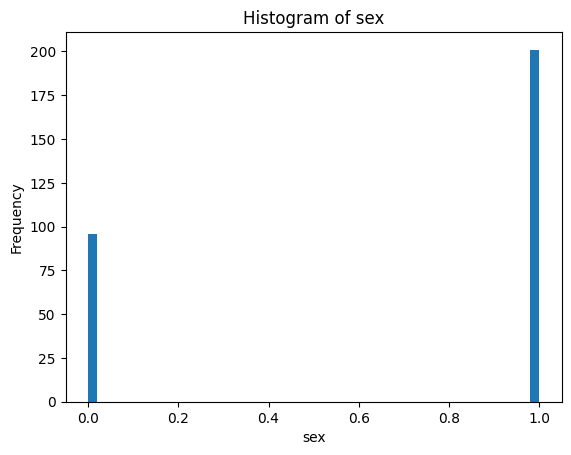

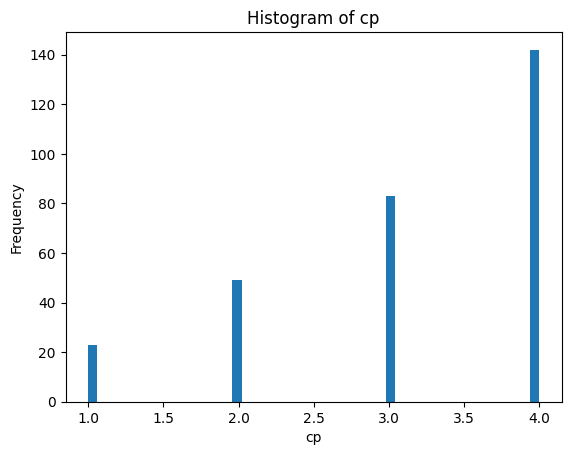

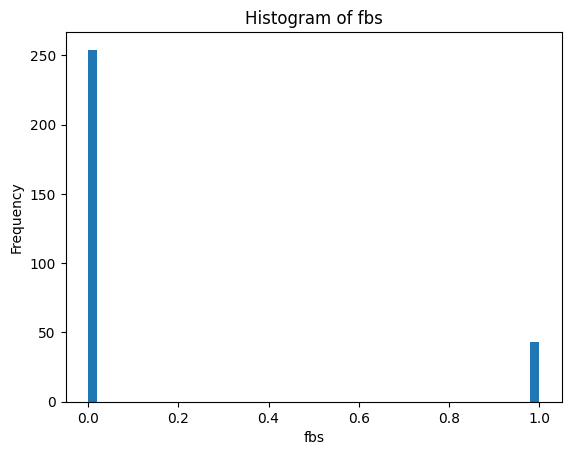

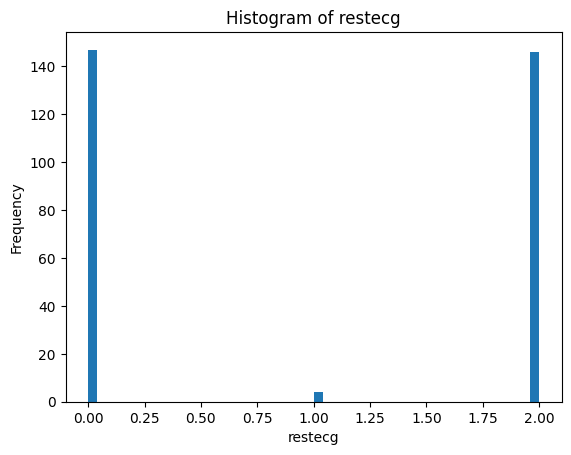

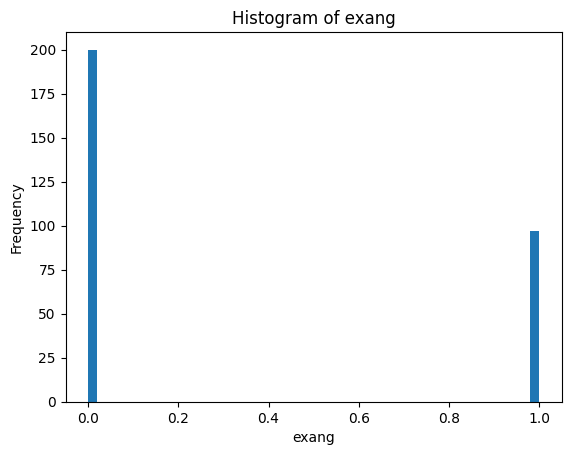

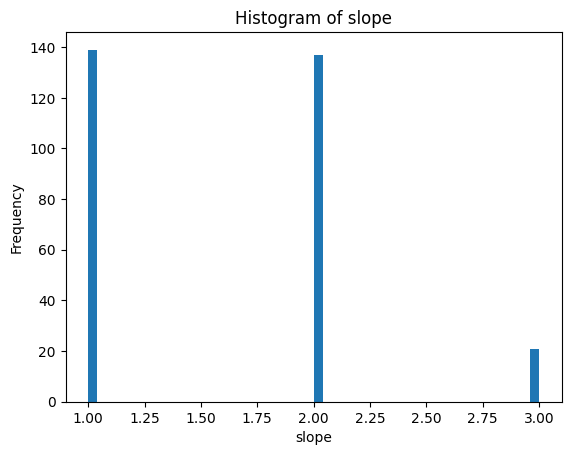

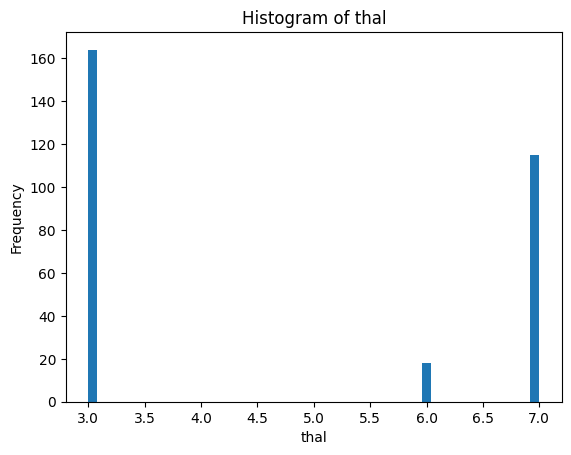

In [8]:
categorical_columns  = vars_df[(vars_df['role'] == 'Feature') & (vars_df['type'] == 'Categorical')]['name']

hd_df = hd_df.apply(pd.to_numeric, errors='coerce')

for col in categorical_columns:
    plt.figure()
    plt.hist(hd_df[col].dropna(), bins=50)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

From the categorical features, we can see that slope, restecg, and cp are all categorical features and need to be one-hot encoded. Let's check the numerical features and make sure we haven't missed any.

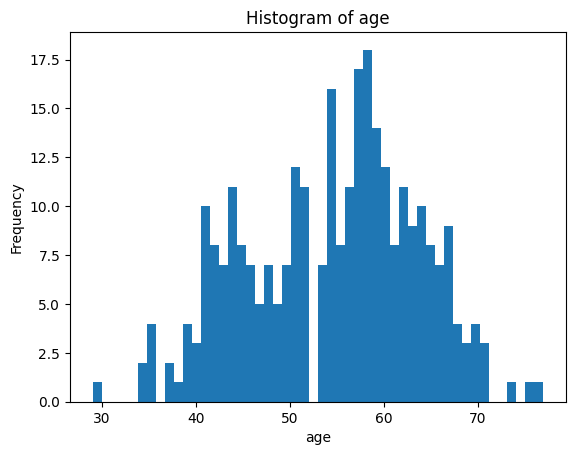

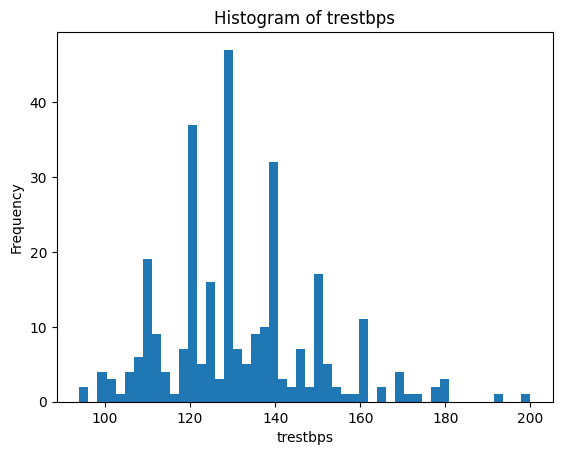

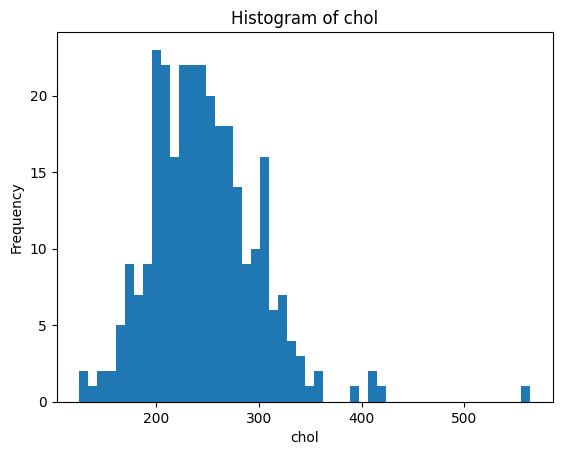

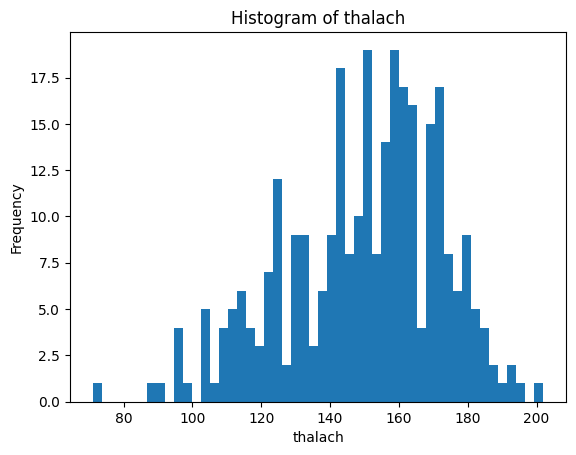

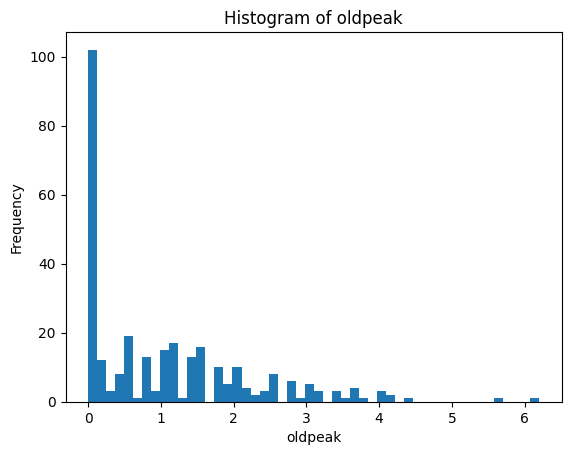

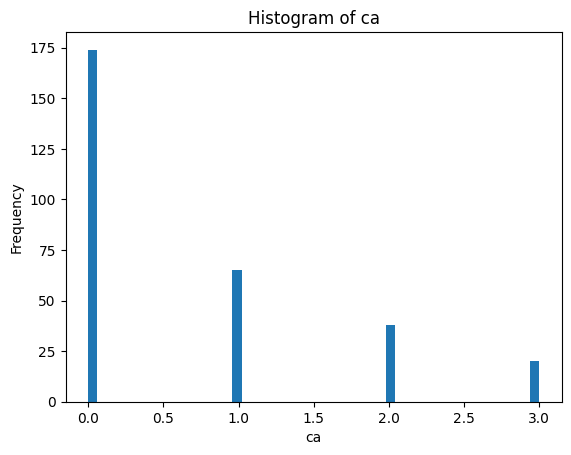

In [9]:
numerical_columns  = vars_df[(vars_df['role'] == 'Feature') & (vars_df['type'] == 'Integer')]['name']

hd_df = hd_df.apply(pd.to_numeric, errors='coerce')

for col in numerical_columns:
    plt.figure()
    plt.hist(hd_df[col].dropna(), bins=50)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Here we see that the feature ca is also categorical, even though it was in the numerical feature category!

In [10]:
hd_df = pd.get_dummies(hd_df, columns=["ca","slope","restecg","cp"], drop_first=True)
hd_df = hd_df.apply(pd.to_numeric, errors='coerce')

boolean_columns = hd_df.select_dtypes(include='bool').columns
hd_df[boolean_columns] = hd_df[boolean_columns].astype(int)

hd_df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,thal,num,ca_1.0,ca_2.0,ca_3.0,slope_2,slope_3,restecg_1,restecg_2,cp_2,cp_3,cp_4
0,63,1,145,233,1,150,0,2.3,6.0,0,0,0,0,0,1,0,1,0,0,0
1,67,1,160,286,0,108,1,1.5,3.0,1,0,0,1,1,0,0,1,0,0,1
2,67,1,120,229,0,129,1,2.6,7.0,1,0,1,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3.5,3.0,0,0,0,0,0,1,0,0,0,1,0
4,41,0,130,204,0,172,0,1.4,3.0,0,0,0,0,0,0,0,1,1,0,0


Seeing that there are no significant outliers, we can continue with the standardization. 

In [11]:
hd_df = hd_df.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x # this operation will automatically convert the data to float64
)

### 1.3a Basic Statistics (Heart Disease UCI)

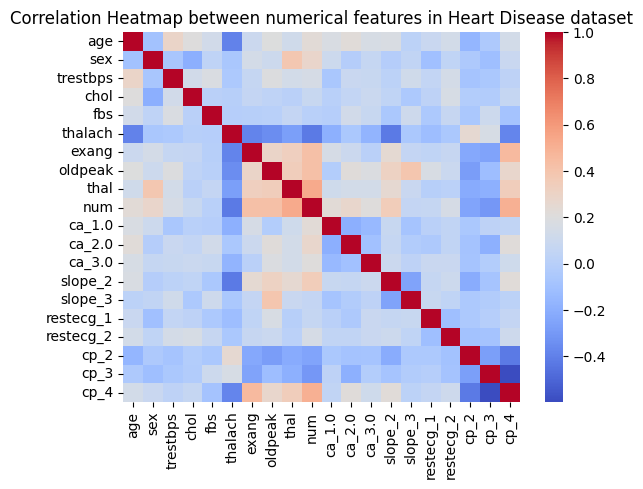

In [12]:
# Correlation matrix for the heart disease dataset
corr_hd = hd_df.corr()
sns.heatmap(corr_hd, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap between numerical features in Heart Disease dataset')
plt.show()

From the correlation matrix, we can see that the numerical variables are not highly correlated with each other. This is good news for our classification model, as it means that the variables are likely to be informative.

In [13]:
# Compute the mean and std of each feature for the positive group
features_by_num = hd_df.groupby("num")
mean_by_num = features_by_num.mean()
std_by_num = features_by_num.std()

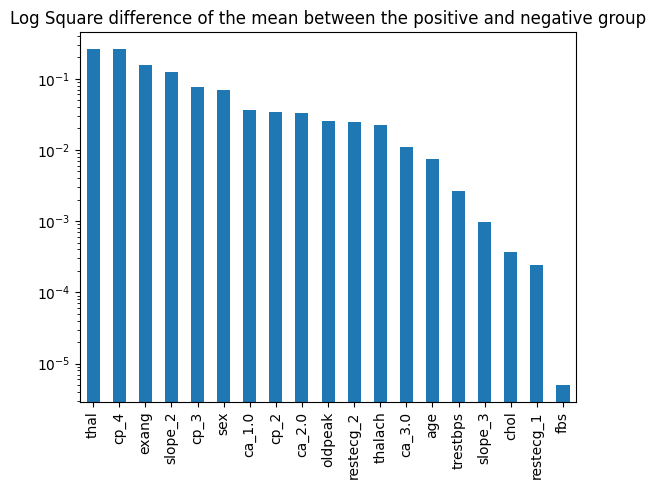

In [14]:
# Squared difference of the mean between the positive and negative group
square_diff = ((mean_by_num.loc[1] - mean_by_num.loc[0]) ** 2).sort_values(ascending=False)
square_diff.plot(kind='bar')
plt.yscale('log')
plt.title('Log Square difference of the mean between the positive and negative group')
plt.show()

We can immediately see that the categorical feature fbs is likely unassociated with the target variable. We can confirm this suspicion with a simple Chi-squared test. Recall the Chi-squared test is used to determine whether there is a significant association between two categorical variables, i.e. `fbs` and `num`.

In [15]:
for feature in hd_df.columns:
    contingency_table = pd.crosstab(hd_df[feature], hd_df['num'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("====================================")
    print(f"Chi-square value for {feature}:", chi2)
    print(f"p-value for {feature}:", p)

Chi-square value for age: 53.17408478309208
p-value for age: 0.07936752862621363
Chi-square value for sex: 21.851612168613475
p-value for sex: 2.945690038078843e-06
Chi-square value for trestbps: 47.49207055844256
p-value for trestbps: 0.5343991971375178
Chi-square value for chol: 174.19686815693433
p-value for chol: 0.09511112041358871
Chi-square value for fbs: 0.0
p-value for fbs: 1.0
Chi-square value for thalach: 110.31825371480707
p-value for thalach: 0.07182861984832394
Chi-square value for exang: 50.9425597633616
p-value for exang: 9.510884265909016e-13
Chi-square value for oldpeak: 84.70053755591232
p-value for oldpeak: 3.151884490537785e-05
Chi-square value for thal: 82.46014428007756
p-value for thal: 1.2416728386228762e-18
Chi-square value for num: 292.9894978052448
p-value for num: 1.109642575703169e-65
Chi-square value for ca_1.0: 14.480297429070507
p-value for ca_1.0: 0.00014163322114955253
Chi-square value for ca_2.0: 20.432327147813186
p-value for ca_2.0: 6.1777392436485

The Chi-squared test for `fbs` shows that the feature is not associated with the target variable. We will drop it from the dataset. We can be even more rigorous by examining the significance of the correlation of each feature to our output features. This will quantify whether each feature independently is informative in differentiating classes.

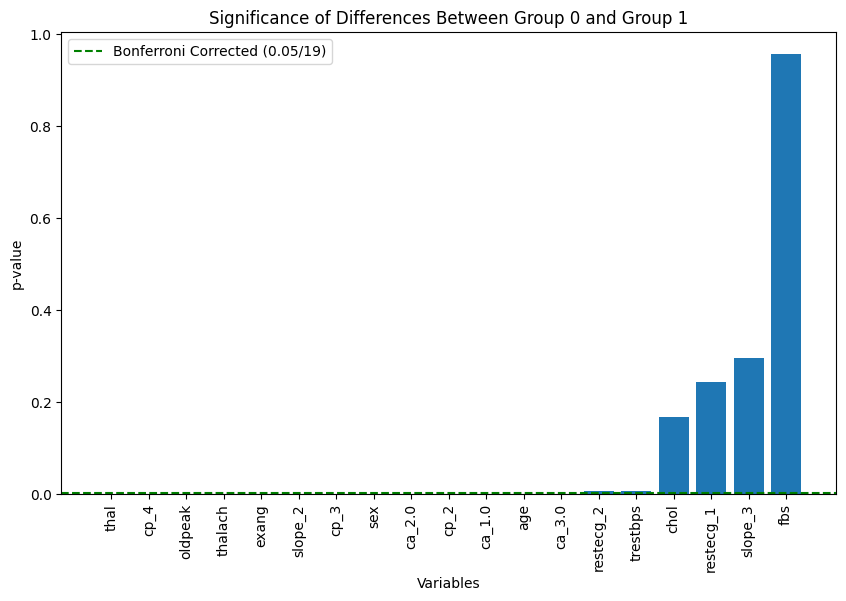

In [16]:
from scipy.stats import ttest_ind

# Split the data into groups
group_0 = hd_df[hd_df['num'] == 0]
group_1 = hd_df[hd_df['num'] == 1]

# Perform t-test for each variable
p_values = {}
for col in group_0.columns:
    if col != 'num':
        t_stat, p_val = ttest_ind(group_0[col].dropna(), group_1[col].dropna(), nan_policy='omit')
        p_values[col] = p_val


sorted_p_values = dict(sorted(p_values.items(), key=lambda item: item[1]))

num_tests = len(sorted_p_values)
bonferroni_corrected_p_value = 0.05 / num_tests

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.bar(sorted_p_values.keys(), sorted_p_values.values())
plt.axhline(y=bonferroni_corrected_p_value, color='g', linestyle='--', label=f'Bonferroni Corrected (0.05/{num_tests})')
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('p-value')
plt.title('Significance of Differences Between Group 0 and Group 1')
plt.legend()
plt.show()

Here we can see that, with a bonferroni-corrected p-value, fbs, slope_3, restecg_1, and chol are all producing non-significant associations to our outcome variable. restecg_2 and trestbps are close, but we will leave them in for now.

### 1.4a Feature Selection (Heart Disease UCI)

In [17]:
class HeartDiseasePreprocessor:
    def __init__(self):
        self.integer_columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
        self.columns_to_one_hot_encode = ["ca","slope","restecg","cp"]
        self.min_vals = {}
        self.max_vals = {}
        self.final_columns = None

    def fit(self, df):
        """
        Fit the preprocessor on the training data. 
        Stores the min/max values and the final columns after one-hot encoding.
        """
        
        # Convert to numeric
        df = df.apply(pd.to_numeric, errors='coerce')

        # Replace '?' with None
        df = df.replace('?', None)

        # Convert target to binary (num > 0 => 1, else 0)
        df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

        # Drop rows with missing values
        df.dropna(inplace=True)
        
        # One-hot encode specified columns
        df = pd.get_dummies(df, columns=self.columns_to_one_hot_encode, dtype=int)
        
        # Compute and store min/max
        for col in df.columns:
            self.min_vals[col] = df[col].min()
            self.max_vals[col] = df[col].max()
        
        # Drop uninformative columns
        df = df.drop(columns=['fbs', "chol", "restecg_1", "slope_3"])
        # Store final columns for later use
        self.final_columns = df.columns

    def transform(self, df):
        """
        Transform the test data using min/max from the fitted training data,
        applying the same cleaning, binarization, and one-hot encoding.
        """

        # Convert target to binary (num > 0 => 1, else 0)
        df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

        # Drop rows with missing values
        df.dropna(inplace=True)

        # One-hot encode
        df = pd.get_dummies(df, columns=self.columns_to_one_hot_encode, dtype=int)
        
        # Normalize using stored min/max
        for col in df.columns:
            min_val = self.min_vals.get(col, None)
            max_val = self.max_vals.get(col, None)
            if min_val is not None and max_val is not None and min_val != max_val:
                df[col] = (df[col] - min_val) / (max_val - min_val)

        

        # Ensure test set has same columns as training set
        missing_cols = set(self.final_columns) - set(df.columns)
        for col in missing_cols:
            df[col] = 0
        # Reorder columns
        df = df[self.final_columns]

        return df


### 1.2b Data cleaning (Penguin)

In [18]:
# Find NaN values in the dataset
nan_count_df = raw_penguin.isna().sum()
nan_count_df = nan_count_df[nan_count_df > 0]
nan_count_df

culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [19]:
penguin_df = raw_penguin.dropna().copy()

In [20]:
penguin_df.dropna(inplace=True)

Before performing normalization, we will first check for outliers.

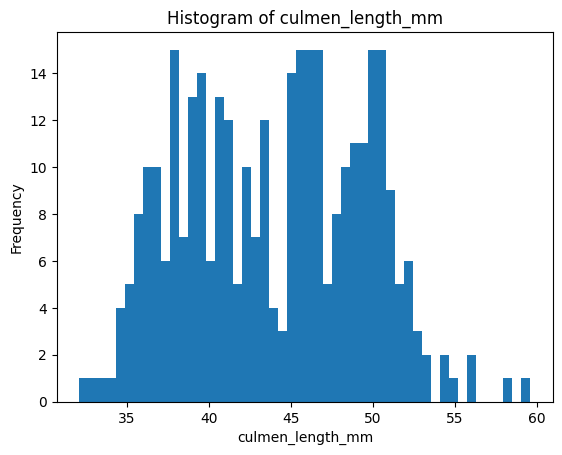

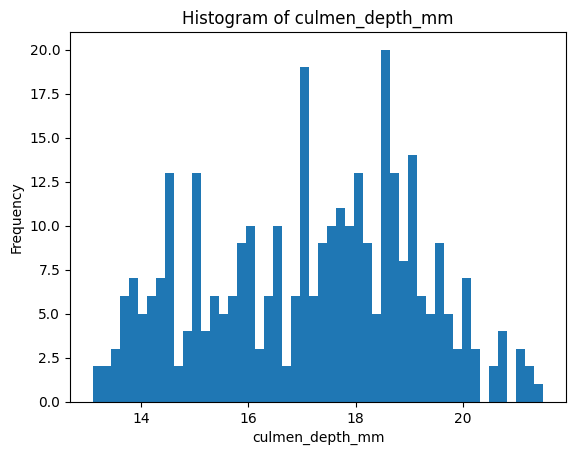

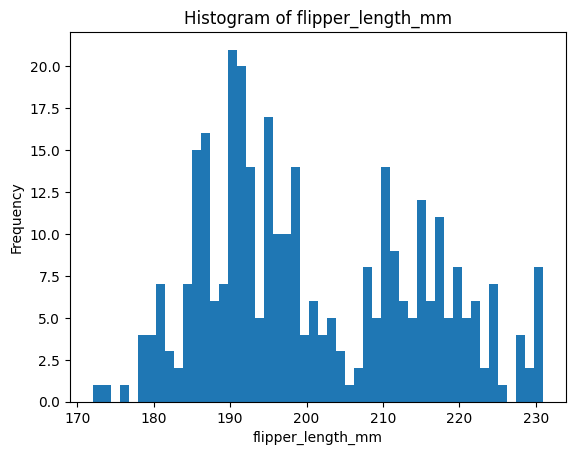

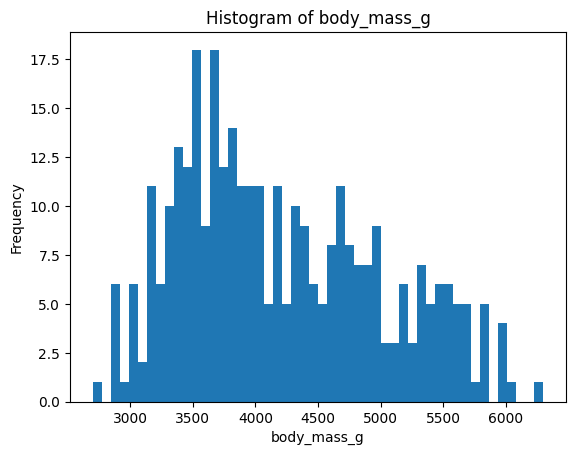

In [21]:
# Select integer columns
numeric_columns = ["culmen_length_mm","culmen_depth_mm","flipper_length_mm","body_mass_g"]

# Plot each column as a histogram
for col in numeric_columns:
    plt.figure()
    plt.hist(penguin_df[col].dropna(), bins=50)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

We standardize the numerical variables

In [22]:
numerical_penguin = penguin_df.select_dtypes(exclude=['object']).columns.tolist()

penguin_df[numerical_penguin] = penguin_df[numerical_penguin].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    )

We should also convert the categorical variables in string format to integer format.

In [23]:
penguin_df['sex'] = penguin_df['sex'].apply(lambda x : 1 if x == "MALE" else 0)

We will convert the categorical variables to numerical format.

In [24]:
penguin_df['species'] = penguin_df['species'].map({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})


### 1.3b Basic Statistics (Penguin)

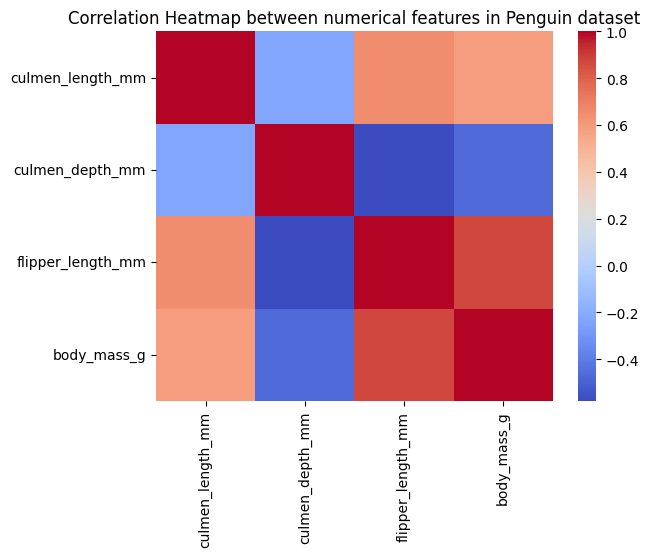

In [25]:
# Correlation matrix for the penguin dataset
corr_penguin = penguin_df[numerical_penguin].corr()  
sns.heatmap(corr_penguin, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap between numerical features in Penguin dataset')
plt.show()

From the correlation matrix, we can see that `body_mass_g` and `flipper_length_mm` are highly correlated (0.87) with each other. As a result, much of the variance in one variable can be explained by the other. This is not ideal for our classification model, as it can lead to multicollinearity. 

In [26]:
# mean and std of each feature for each species
features_by_species = penguin_df.groupby("species")
mean_by_species = features_by_species.mean()
std_by_species = features_by_species.std()

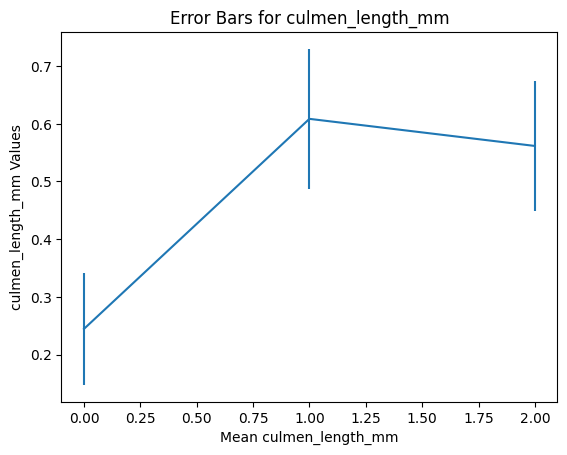

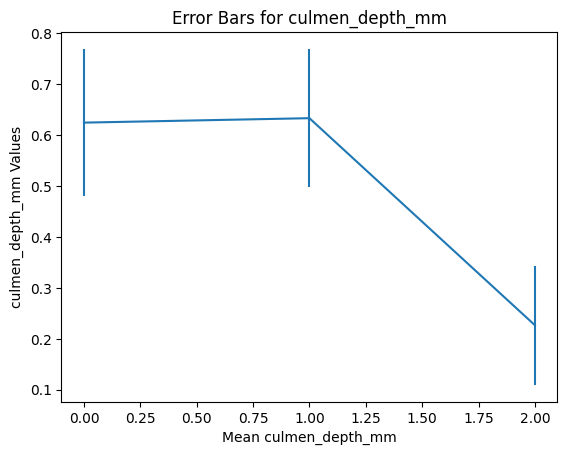

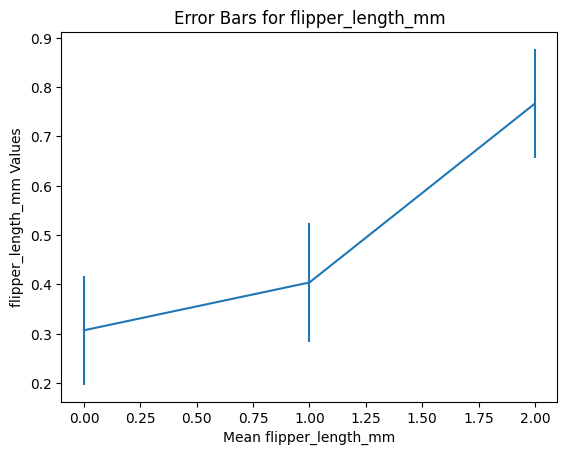

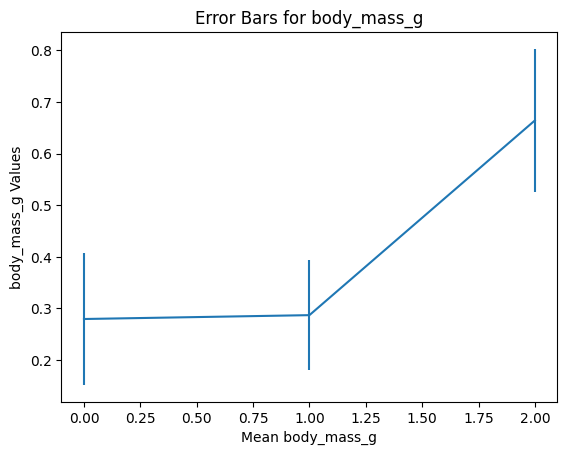

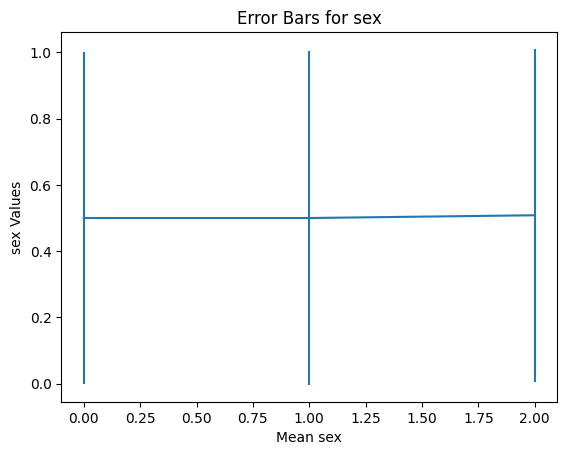

In [27]:
for feature in mean_by_species.columns:
    means = mean_by_species[feature]
    stds = std_by_species[feature]
    plt.errorbar(means.index, means, yerr=stds)
    plt.xlabel(f'Mean {feature}')
    plt.ylabel(f'{feature} Values')
    plt.title(f'Error Bars for {feature}')
    plt.show()

In [28]:
# chi squared test for sex
contingency_table = pd.crosstab(penguin_df['sex'], penguin_df['species'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi square value: {chi2}")
print(f"p-value: {p}")

Chi square value: 0.021358051252629347
p-value: 0.9893777927330816


As shown in the Chi-squared test, there is very little evidence that `sex` is associated with the target variable `species`. To confirm this, we will also run a similar significance test on all variables.

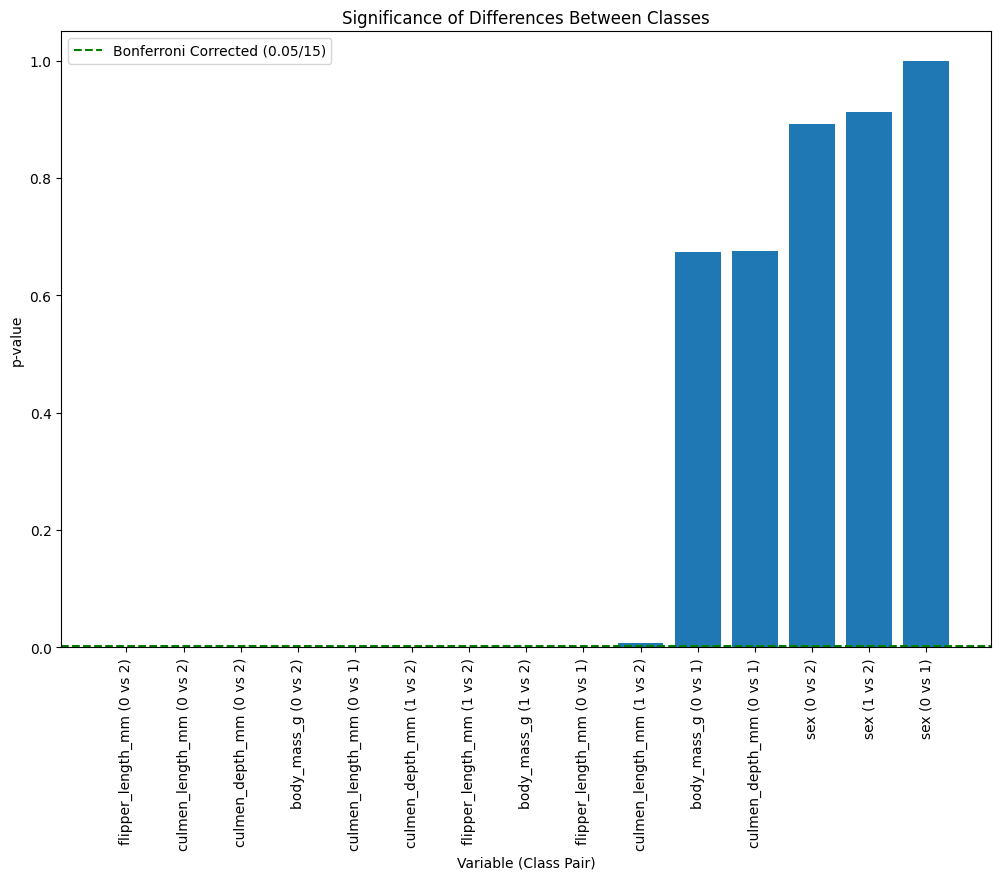

In [29]:
# Get unique classes
unique_classes = penguin_df['species'].unique()

# Perform pairwise t-tests for each variable
p_values = {}
for i in range(len(unique_classes)):
    for j in range(i + 1, len(unique_classes)):
        class_i = unique_classes[i]
        class_j = unique_classes[j]
        group_i = penguin_df[penguin_df['species'] == class_i]
        group_j = penguin_df[penguin_df['species'] == class_j]
        
        for col in group_i.columns:
            if col != 'species':
                t_stat, p_val = ttest_ind(group_i[col].dropna(), group_j[col].dropna(), nan_policy='omit')
                p_values[f'{col} ({class_i} vs {class_j})'] = p_val

# Sort p-values from smallest to largest
sorted_p_values = dict(sorted(p_values.items(), key=lambda item: item[1]))

# Calculate the Bonferroni corrected p-value
num_tests = len(sorted_p_values)
bonferroni_corrected_p_value = 0.05 / num_tests

# Plot the p-values
plt.figure(figsize=(12, 8))
plt.bar(sorted_p_values.keys(), sorted_p_values.values())
plt.axhline(y=bonferroni_corrected_p_value, color='g', linestyle='--', label=f'Bonferroni Corrected (0.05/{num_tests})')
plt.xticks(rotation=90)
plt.xlabel('Variable (Class Pair)')
plt.ylabel('p-value')
plt.title('Significance of Differences Between Classes')
plt.legend()
plt.show()

From this, we can see clearly that penguin sex is not useful at differentiating any of the penguin types, so it can be excluded.

### 1.4b Feature selection

In [35]:
class PenguinPreprocessor:
    def __init__(self):
        # Attributes to store min and max values after fitting
        self.min_vals = {}
        self.max_vals = {}
        self.integer_columns = [
            "culmen_length_mm", 
            "culmen_depth_mm",
            "body_mass_g", 
        ]

    def fit(self, df):
        """
        Drops unused columns, maps categories to numeric,
        and stores min/max values for integer columns.
        """
        input_df = df.copy()
        # Drop columns
        input_df.drop(["Island"], axis=1, inplace=True, errors='ignore')
        input_df.dropna(inplace=True)
        input_df['species'] = input_df['species'].map({
            'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2
        })
        input_df.drop(["sex", 'flipper_length_mm'], axis=1, inplace=True, errors='ignore')
        input_df.dropna(inplace=True)
        
        # Store min and max from the fitted DataFrame
        for col in self.integer_columns:
            self.min_vals[col] = input_df[col].min()
            self.max_vals[col] = input_df[col].max()

    def transform(self, df):
        """
        Applies the same preprocessing and normalization steps
        using stored min and max values to avoid data leakage.
        """
        # Drop columns
        df.drop(["Island"], axis=1, inplace=True, errors='ignore')
        df.dropna(inplace=True)
        df['species'] = df['species'].map({
            'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2
        })
        df.drop(["sex"], axis=1, inplace=True, errors='ignore')
        df.dropna(inplace=True)
        
        # Scale the columns using the stored min/max
        for col in self.integer_columns:
            min_val = self.min_vals.get(col, None)
            max_val = self.max_vals.get(col, None)
            if min_val is not None and max_val is not None and min_val != max_val:
                df[col] = (df[col] - min_val) / (max_val - min_val)
        return df
    
preprocessor = PenguinPreprocessor()
preprocessor.fit(raw_penguin.copy())
penguin_train_data = preprocessor.transform(raw_penguin.copy())

penguin_features = penguin_train_data.drop(columns=['species']).values
penguin_labels = penguin_train_data['species'].values


## 2. Model Implementation - KNN and Decision Tree

### 2.1 KNN Implementation from Scratch

Distance functions

In [36]:
def lp_dist(X_1: torch.Tensor, X_2: torch.Tensor, p=2) -> float:
    assert X_1.shape[-1] == X_2.shape[-1]
    diff = X_1.unsqueeze(-3) - X_2.unsqueeze(-2) # broadcasting
    return torch.pow(torch.sum(torch.abs(diff) ** p, dim=-1), 1/p)

In [37]:
def cosine_sim(X_1: torch.Tensor, X_2: torch.Tensor) -> float:
    assert X_1.shape[-1] == X_2.shape[-1]
    X_1_norm = torch.norm(X_1, dim=-1, keepdim=True)
    X_2_norm = torch.norm(X_2, dim=-1, keepdim=True)
    return torch.matmul(X_2, X_1.T) / torch.matmul(X_2_norm, X_1_norm.T)

KNN algorithm

In [38]:
class KNNClassifierScratch:
    def __init__(self, dist_fn=lp_dist, k=3):
        self.dist_fn = dist_fn # prefer to keep it here for modular design
        self.k = k # prefer to keep it here for modular design
        
    def fit(self, X, y):
        assert X.shape[0] == y.shape[0]
        if X.dim() == 1:
            X = X.unsqueeze(-1)
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        self.X_test = X
        if X.dim() == 1:
            self.X_test = X.unsqueeze(-1)
        dist_matrix = self.dist_fn(self.X_train, self.X_test)
        knn_idx = torch.topk(dist_matrix, self.k, dim=-1, largest=False).indices
        knn_y = self.y_train[knn_idx] # address singleton?!?
        y_hat = torch.mode(knn_y, dim=-1).values
        return y_hat

    def evaluate_acc(self, y_true, y_hat):
        assert y_true.shape == y_hat.shape
        num_correct = (y_hat == y_true).sum().item()
        N = y_true.shape[0]
        return num_correct / N

### 2.2 Decision Tree Implementation

Cost functions

In [39]:
def cost_misclassification(labels: torch.tensor) -> float:
    unique_labels, counts = torch.unique(labels, return_counts=True)
    class_probs = counts.float() / labels.shape[-1]
    return torch.min(class_probs)  # min(p, 1-p)

def cost_entropy(labels: torch.tensor) -> float:
    unique_labels, counts = torch.unique(labels, return_counts=True)
    class_probs = counts.float() / labels.shape[-1]
    class_probs = class_probs[class_probs > 0]
    return torch.sum(-class_probs * torch.log2(class_probs))

def cost_gini_idx(labels: torch.tensor) -> float:
    unique_labels, counts = torch.unique(labels, return_counts=True)
    class_probs = counts.float() / labels.shape[-1]
    return 1 - torch.sum(torch.square(class_probs))


In [40]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    # stores the data indices which are in the region defined by this node
        self.left = None                                    # stores the left child of the node
        self.right = None                                   # stores the right child of the node
        self.split_feature = None                           # the feature for split at this node
        self.split_value = None                             # the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   # obtain the depth of the node by adding one to depth of the parent
            self.num_classes = int(parent.num_classes)      # copies the num classes from the parent and ensures it is an integer
            self.data = parent.data                         # copies the data from the parent
            self.labels = parent.labels                     # copies the labels from the parent
            unique_labels, counts = torch.unique(self.labels[data_indices], return_counts=True)
            unique_labels = unique_labels.long()            # ensure unique_labels is of type long
            class_prob = torch.zeros(self.num_classes)
            class_prob[unique_labels] = counts.float()
            self.class_prob = class_prob / torch.sum(class_prob)  # stores the class probability for the node

In [41]:
def greedy_test(node, cost_fn):
    best_cost = torch.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted, _ = torch.sort(node.data[node.data_indices], dim=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost) / num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Decision tree algorithm

In [42]:
class DecisionTreeScratch:
    def __init__(self, num_classes=None, cost_fn=cost_gini_idx, max_depth=5, min_leaf_instances=1):
        self.cost_fn = cost_fn
        self.max_depth = max_depth
        self.min_leaf_instances = min_leaf_instances
        self.root = None
        self.num_classes = num_classes
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        if self.num_classes is None:
            self.num_classes = torch.max(self.y_train) + 1
        #below are initialization of the root of the decision tree
        self.root = Node(torch.arange(self.X_train.shape[0]), None)
        self.root.data = self.X_train
        self.root.labels = self.y_train
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        self.feature_count = torch.zeros(X.shape[-1])
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if torch.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        self.feature_count[split_feature] += 1
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[torch.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present child
        node.left = left
        node.right = right
    
    def predict(self, X):
        self.X_test = X
        class_probs = torch.zeros((self.X_test.shape[0], int(self.num_classes)))
        for n, x in enumerate(self.X_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
        return torch.argmax(class_probs, dim=-1)
    
    def evaluate_acc(self, y_true, y_hat):
        assert y_true.shape == y_hat.shape, f"y_true shape {y_true.shape} mismatch y_hat shape {y_hat.shape}"
        num_correct = (y_hat == y_true).sum().item()
        N = y_true.shape[0]
        return num_correct / N
    
    def get_top_k_features(self, k=5):
        assert self.feature_count is not None, "Decision Tree has not been fitted yet"
        return torch.topk(self.feature_count, k=min(self.num_classes, k))


## 3. Model Evaluation

### 3.1 Comparing KNN and Decision Trees

AUROC Comparison on Heart Disease UCI dataset

The cross-validator needs to be created specially to prevent the normalization from leaking information about the distributions in the testing and validation sets.

In [43]:
def compare_auroc(
        df,
        preprocessor,
        models: list[dict],
        label: str,
        title: str,
        nfolds=5,
        use_test_set=False,
        test_size=0.2,
        model_name=None, 
        save_path=None):
    
    # Split the data into train and test sets
    train_idx, test_idx = train_test_split(np.arange(df.shape[0]), test_size=test_size, random_state=42)
    
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()
    
    
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
    
    for model_dict in models:
        model_name, model = model_dict["name"], model_dict["model"]
        val_tprs, val_fprs, val_aucs = [], [], []
        test_tprs, test_fprs, test_aucs = [], [], []
        
        for train_idx, val_idx in kf.split(train_df):
            train_split_df = train_df.iloc[train_idx].copy()
            val_split_df = train_df.iloc[val_idx].copy()
            
            # Fit the preprocessor on the training split
            preproc = preprocessor()
            preproc.fit(train_split_df)
            
            # Transform the training and validation splits
            train_split_df = preproc.transform(train_split_df)
            val_split_df = preproc.transform(val_split_df)
            
            X_train = train_split_df.drop(columns=[label]).values
            y_train = train_split_df[label].values
            X_val = val_split_df.drop(columns=[label]).values
            y_val = val_split_df[label].values
            
            X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)
            y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)
            
            # Train model
            model.fit(X_train, y_train)
            
            if not use_test_set:
                # Validation set roc and auroc
                y_hat = model.predict(X_val)
                val_fpr, val_tpr, _ = roc_curve(y_val, y_hat)
                val_auc = roc_auc_score(y_val, y_hat)
                val_tprs.append(val_tpr); val_fprs.append(val_fpr); val_aucs.append(val_auc)
            else:
                test_df_proc = preproc.transform(test_df)
                X_test = test_df_proc.drop(columns=[label]).values
                y_test = test_df_proc[label].values
            
                X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
                
                # Test set roc and auroc
                y_hat = model.predict(X_test)
                test_fpr, test_tpr, _ = roc_curve(y_test, y_hat)
                test_auc = roc_auc_score(y_test, y_hat)
                test_tprs.append(test_tpr); test_fprs.append(test_fpr); test_aucs.append(test_auc)
        
        # Plot average model performance over K folds
        if not use_test_set:
            val_mean_tpr, val_mean_fpr, val_mean_auc = np.mean(val_tprs, axis=0), np.mean(val_fprs, axis=0), np.mean(val_aucs)
            plt.plot(val_mean_fpr, val_mean_tpr, label=f"{model_name}: Val AUC = {val_mean_auc:.2f}")
        else:
            test_mean_tpr, test_mean_fpr, test_mean_auc = np.mean(test_tprs, axis=0), np.mean(test_fprs, axis=0), np.mean(test_aucs)
            plt.plot(test_mean_fpr, test_mean_tpr, label=f"{model_name}: Test AUC = {test_mean_auc:.2f}")

    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [44]:
models = [
    {"name": "KNN", "model": KNNClassifierScratch()},
    {"name": "DT", "model": DecisionTreeScratch()}]

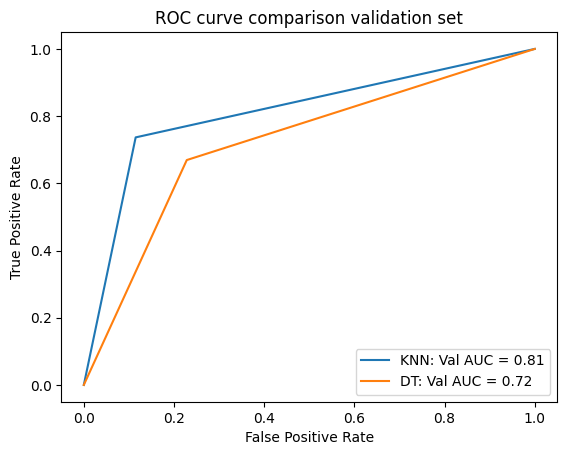

In [45]:
compare_auroc(df=raw_hd, preprocessor=HeartDiseasePreprocessor, label='num', models=models, title="ROC curve comparison validation set")

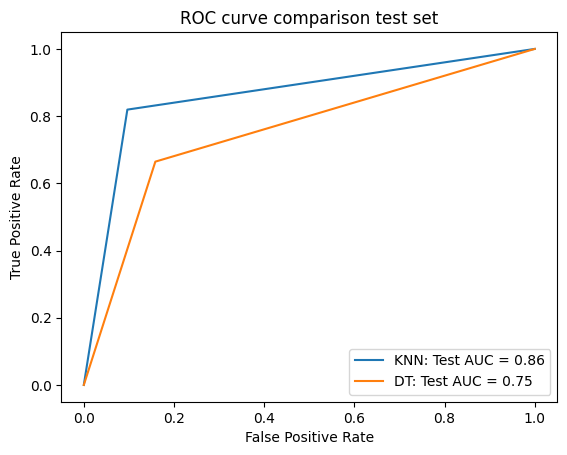

In [46]:
compare_auroc(df=raw_hd, preprocessor=HeartDiseasePreprocessor, label='num', models=models, title="ROC curve comparison test set", use_test_set=True)

Accuracy Comparison on Penguin dataset

In [47]:
def compare_acc(
        df,
        preprocessor,
        models: list[dict],
        label: str,
        title: str,
        nfolds=5,
        test_size=0.2,
        model_name=None, 
        save_path=None):
    
    # Split the data into train and test sets
    train_idx, test_idx = train_test_split(np.arange(df.shape[0]), test_size=test_size, random_state=42)
    
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()
    
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
    
    for model_dict in models:
        model_name, model = model_dict["name"], model_dict["model"]
        val_accs = []
        test_accs = []
        
        for train_idx, val_idx in kf.split(train_df):
            train_split_df = train_df.iloc[train_idx].copy()
            val_split_df = train_df.iloc[val_idx].copy()
            
            # Fit the preprocessor on the training split
            preproc = preprocessor()
            preproc.fit(train_split_df)
            
            # Transform the training and validation splits
            train_split_df = preproc.transform(train_split_df)
            val_split_df = preproc.transform(val_split_df)
            
            X_train = train_split_df.drop(columns=[label]).values
            y_train = train_split_df[label].values
            X_val = val_split_df.drop(columns=[label]).values
            y_val = val_split_df[label].values
            
            X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)
            y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)
            
            # Train model
            model.fit(X_train, y_train)
            

            y_hat = model.predict(X_val)
            val_acc = model.evaluate_acc(y_val, y_hat)
            val_accs.append(val_acc)

            test_df_proc = preproc.transform(test_df.copy())
            X_test = test_df_proc.drop(columns=[label]).values
            y_test = test_df_proc[label].values
            
            X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
            
            # Test set accuracy
            y_hat = model.predict(X_test)
            test_acc = model.evaluate_acc(y_test, y_hat)
            test_accs.append(test_acc)
        
        # Plot average model performance over K folds

        mean_val_acc = np.mean(val_accs)
        plt.plot(model_name, mean_val_acc, marker='o', color='blue')

        mean_test_acc = np.mean(test_accs)
        plt.plot(model_name, mean_test_acc, marker='d', color='red')
    
    plt.figlegend(['Validation accuracy', 'Test accuracy'])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [48]:
models = [
    {"name": "KNN", "model": KNNClassifierScratch()},
    {"name": "DT", "model": DecisionTreeScratch()}
]

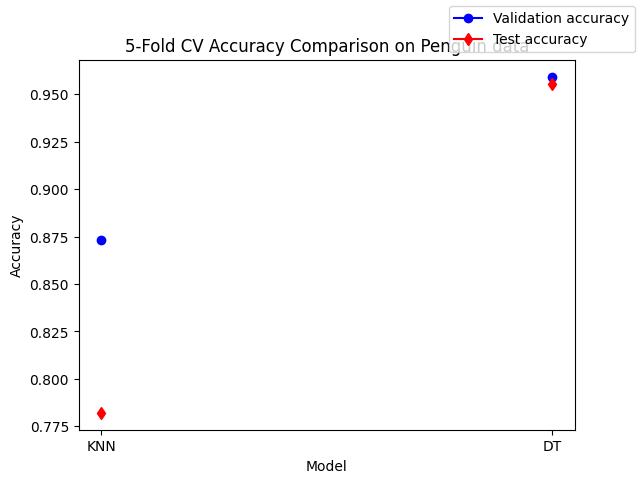

In [49]:
compare_acc(
    raw_penguin, 
    PenguinPreprocessor,
    models,
    label='species', 
    title="5-Fold CV Accuracy Comparison on Penguin data")

### 3.2 KNN Hyperparameter Tuning

In [50]:
models = [{"name": f"KNN (k={k})", "model": KNNClassifierScratch(k=k)} for k in range(1, 11, 2)]

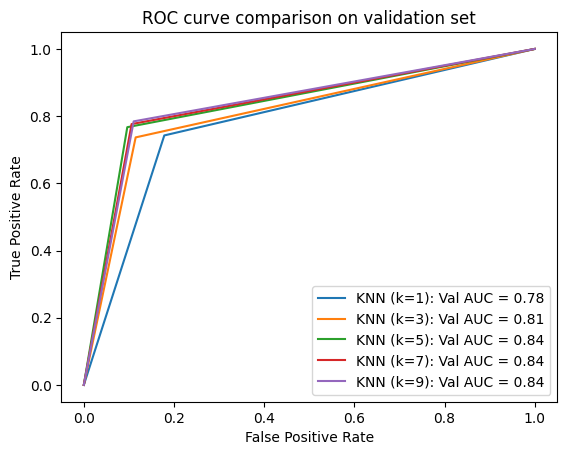

In [51]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC curve comparison on validation set"
    )

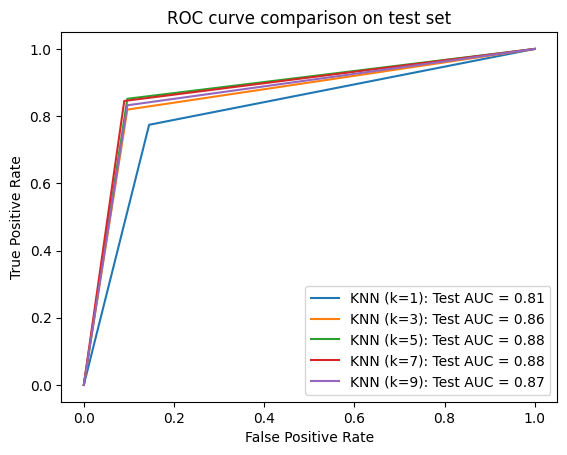

In [52]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC curve comparison on test set",
    use_test_set=True
)

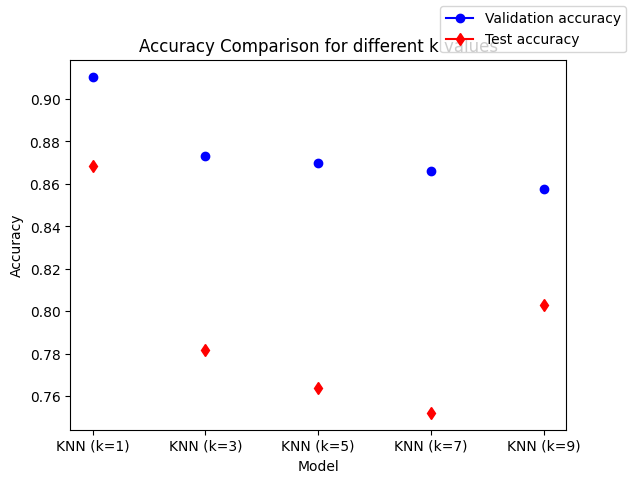

In [53]:
compare_acc(
    raw_penguin, 
    PenguinPreprocessor,
    label='species',
    models=models, 
    title="Accuracy Comparison for different k values")

### 3.3 Decision Trees Hyperparameter Tuning

In [54]:
models = [{
    "name" : f"DT (max_d={d})",
    "model" : DecisionTreeScratch(max_depth=d, num_classes=3)} for d in range(1,10)
    ]

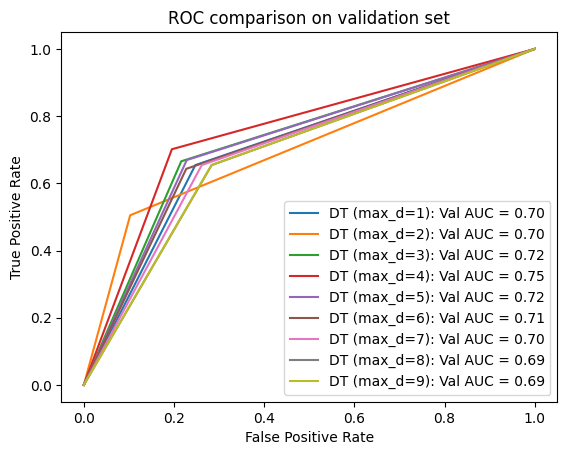

In [55]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC comparison on validation set")

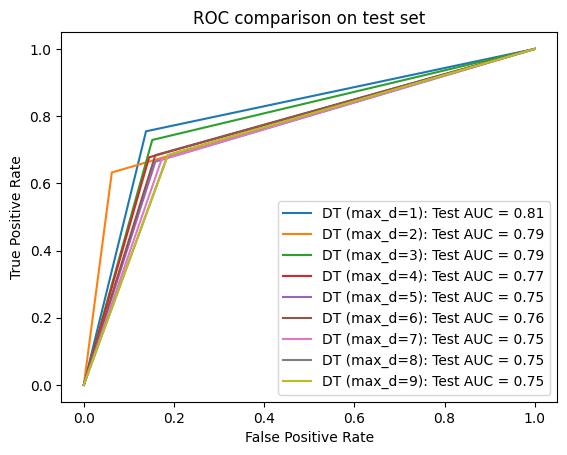

In [56]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    use_test_set=True,
    title="ROC comparison on test set"
    
)

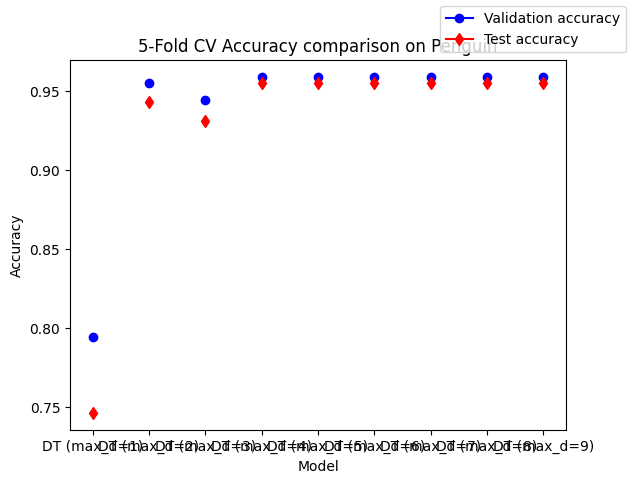

In [57]:
compare_acc(
    raw_penguin, 
    PenguinPreprocessor,
    label='species',
    models=models,
    title="5-Fold CV Accuracy comparison on Penguin")

### 3.4 Distance/Cost Function Comparison

Distance function comparison for KNN (k=3)

In [58]:
from functools import partial

models = [{
    "name": f"KNN (l{p} distance)", 
    "model": KNNClassifierScratch(dist_fn=partial(lp_dist, p=p))} for p in range(1, 6)] \
     + [{
    "name": "KNN (cosine similarity)", 
    "model": KNNClassifierScratch(dist_fn=cosine_sim)}]

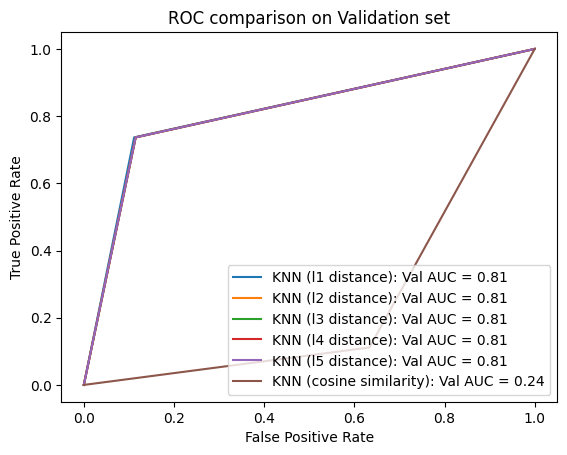

In [59]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC comparison on Validation set")

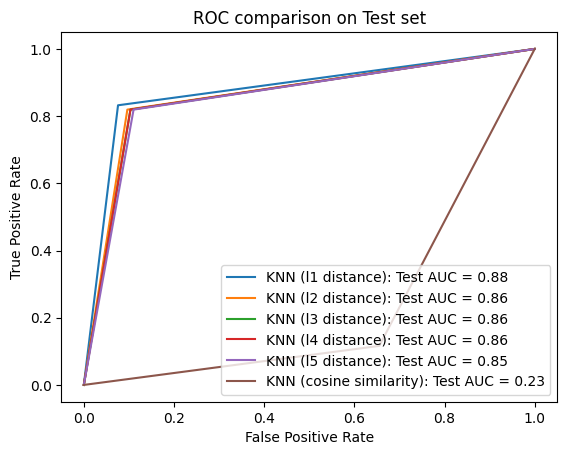

In [60]:

compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC comparison on Test set",
    use_test_set=True)

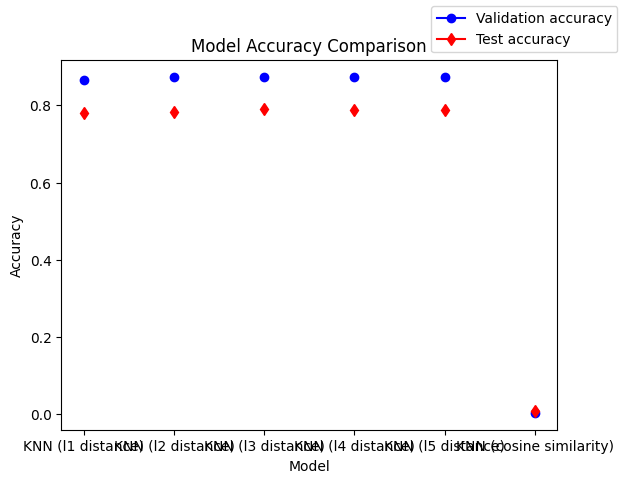

In [61]:
compare_acc(
    raw_penguin, 
    PenguinPreprocessor,
    label='species',
    models=models,
    title="Model Accuracy Comparison")

Cost function comparison for DT (max_depth=5)

In [62]:
cost_fns = [
    cost_misclassification,
    cost_entropy,
    cost_gini_idx
]
models = [{
    "name": f"DT ({fn.__name__})", 
    "model": DecisionTreeScratch(max_depth=5, cost_fn=fn, num_classes=3)} for fn in cost_fns
    ]

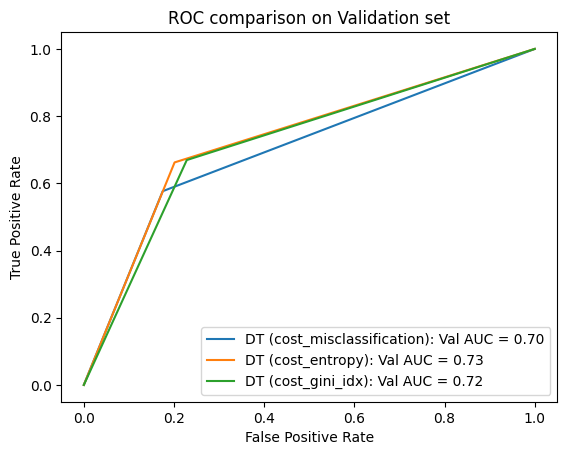

In [63]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC comparison on Validation set")

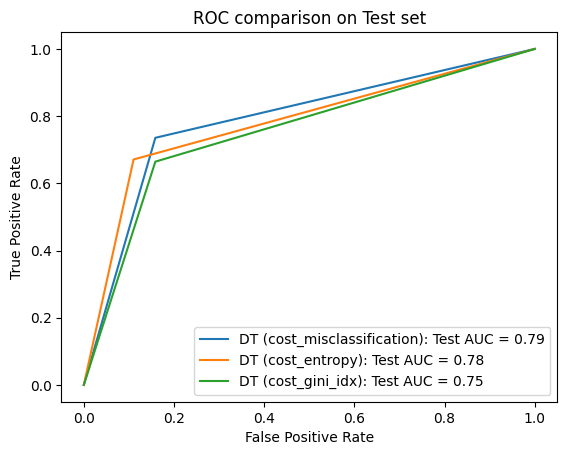

In [64]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC comparison on Test set",
    use_test_set=True
)

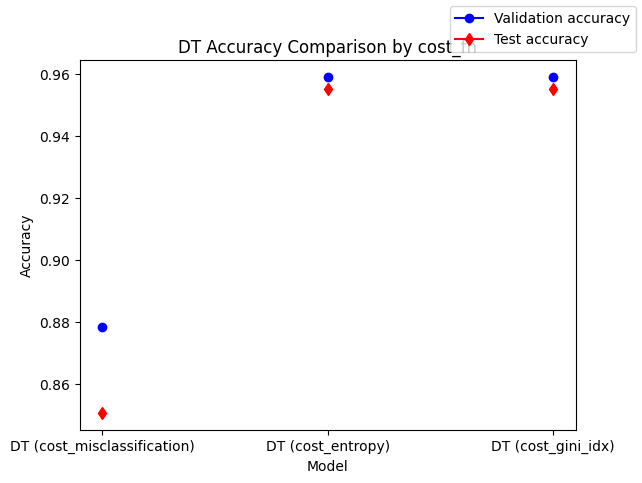

In [65]:
compare_acc(
    raw_penguin, 
    PenguinPreprocessor,
    label='species',
    models=models,
    title="DT Accuracy Comparison by cost_fn")

### 3.5 ROC Comparison - KNN vs DT

In [66]:
models = [
    {"name": "KNN", "model": KNNClassifierScratch()},
    {"name": "DT", "model": DecisionTreeScratch()}]

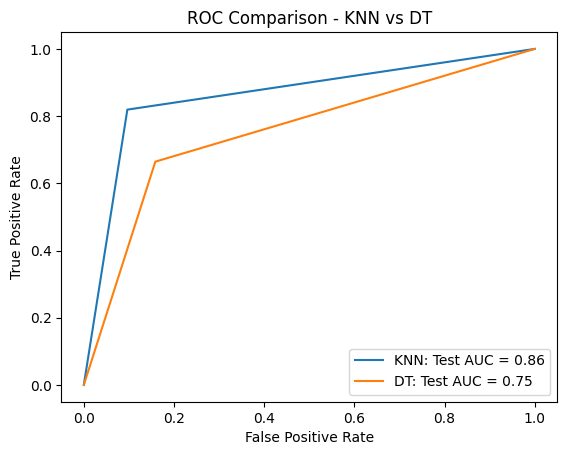

In [67]:
compare_auroc(
    df=raw_hd, 
    preprocessor=HeartDiseasePreprocessor, 
    label='num',
    models=models,
    title="ROC Comparison - KNN vs DT",
    use_test_set=True)

### 3.6 Feature Selection for KNN

For both datasets, a preprocessor was created which helped to prevent data leakage by normalizing data using the summary statistics of the training data set, mimicing real-world conditions. This additionally prevents cases where a test/validation set has different minimum/maximums relative to the training dataset, which will result in a numeric shift. 

#### 3.6.1 Heart Disease UCI

`fb` has the lowest squared mean difference by target group. Additionally, a Chi-squared test showed statistically significant evidence of independence with target. This feature results in noise that can negatively impact the KNN distance function values. Additionally, a t-test run on each feature independently to determine it's association with our output features showed that "chol", which measured cholesterol, was largely unrelated to our label. Additionally, the one-hot encoded features: "restecg_1", corresponding to a "normal" ecg, and "slope_3", corresponding to a downsloping ST both did not have very different values across the labels. This test could miss non-linear relationships, but it is helpful in removing noisy features.

#### 3.6.2 Penguin Dataset

`Flipper_length` and `body_mass` have very high correlation (0.87) meaning KNN distance functions will add more significance to the weight of the correlated pair. Because both showed similarly strong influences on the outcome, `flipper_length` was removed arbitrarily.

`Sex` adds noise to the KNN distance functions: mean and std deviation by group is relatively the same. Also chi-squared test yields no evidence of association with the target. This is seen as well when performing a t-test on each class indivisually. `Sex` is not useful in differentiating any of the classes. Some other classes are not useful at differentiating some classes, but as long as they are useful for the distinction of any class from any other class, they are retained.

### 3.7 Feature Importance for DT

In [68]:
def DT_feature_importance(X, y, max_depth=5, num_classes=None):
    dt = DecisionTreeScratch(max_depth=max_depth, num_classes=num_classes) # DEFAULT: max_depth=5, cost_fn=gini_idx
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = torch.tensor(X[train_idx]), torch.tensor(X[val_idx])
        y_train, y_val = torch.tensor(y[train_idx]), torch.tensor(y[val_idx])
        # Train model
        dt.fit(X_train, y_train)
        print(dt.get_top_k_features(k=5))


In [69]:
hd_features_all = hd_df.drop(columns='num')

In [70]:
hd_labels = hd_df['num'].values

DT_feature_importance(
    hd_features_all.values,
    hd_labels,
    num_classes=hd_features_all.shape[-1]
)

torch.return_types.topk(
values=tensor([11.,  4.,  3.,  2.,  2.]),
indices=tensor([0, 7, 5, 1, 3]))
torch.return_types.topk(
values=tensor([8., 3., 3., 2., 2.]),
indices=tensor([0, 2, 7, 1, 5]))
torch.return_types.topk(
values=tensor([13.,  2.,  2.,  2.,  2.]),
indices=tensor([0, 2, 5, 7, 9]))
torch.return_types.topk(
values=tensor([9., 4., 4., 3., 2.]),
indices=tensor([0, 2, 7, 3, 8]))
torch.return_types.topk(
values=tensor([10.,  3.,  3.,  2.,  2.]),
indices=tensor([ 0,  2,  7,  8, 12]))


In [71]:
hd_features_all.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'thal', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'slope_2', 'slope_3', 'restecg_1',
       'restecg_2', 'cp_2', 'cp_3', 'cp_4'],
      dtype='object')

In [72]:
penguin_features_all = penguin_df.drop(columns='species')

In [73]:
DT_feature_importance(
    penguin_features_all.values,
    penguin_labels,
    max_depth=5,
    num_classes=penguin_features_all.shape[-1])

torch.return_types.topk(
values=tensor([17.,  4.,  1.,  1.,  1.]),
indices=tensor([0, 1, 2, 3, 4]))
torch.return_types.topk(
values=tensor([17.,  3.,  1.,  1.,  0.]),
indices=tensor([0, 1, 2, 3, 4]))
torch.return_types.topk(
values=tensor([15.,  4.,  1.,  1.,  0.]),
indices=tensor([0, 1, 2, 3, 4]))
torch.return_types.topk(
values=tensor([15.,  4.,  1.,  1.,  0.]),
indices=tensor([0, 1, 2, 3, 4]))
torch.return_types.topk(
values=tensor([17.,  4.,  1.,  1.,  1.]),
indices=tensor([0, 1, 2, 3, 4]))


In [74]:
penguin_features_all.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')